## Quantum Discriminator

This jupyter file can be used to reproduce the Figures 2,3 and 9 of the Manuscript.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

import jax
import jax.numpy as jnp
import optax

# from typing import Any, Callable, Sequence, Optional, Iterable
from functools import partial
from flax.training import train_state 

from Bars_and_Stripes_Loader import BASDataset_for_discrimination, NumpyLoader
from Jax_Circuit_helper import circuit_to_execute_D
from Ising_data_helper import IsingDataset_for_discriminator 

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


## Define all variables

In [2]:
batch_size = 4 # training batch size
seed = 1 # random seed

lrG = 0.01  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 1001  # Number of training iterations

depth_D = 20 # circuit depth of D
auxiliary_D = 0 # how many auxiliary qubits does D have
n_work = 8  # Number of qubits used for data encoding
BS_or_Ising = "Ising" # Run training for discriminator for Bars and Stripes or Ising data
max_data = 256 # only for Ising. Maximum amount of labeled states in training set
nr_high_energy_states = 128 # only for Ising. How many of the states are labeled high energy
n_total = n_work + auxiliary_D # total number of qubits of discriminator

key = jax.random.PRNGKey(seed) # Initialize pseudo random number generator
_, subkey = jax.random.split(key)

## Load Dataset

In [3]:
if BS_or_Ising == "BS":
    n_work = 4 # nr of qubits used for data encoding
    image_size = 2 # B&S images are 2x2
    dataset = BASDataset_for_discrimination(transform=None, size=(image_size, image_size))
elif BS_or_Ising == "Ising":
    dataset = IsingDataset_for_discriminator(auxiliary_G = 0, auxiliary_D =  auxiliary_D, 
                                            n_work = n_work, folder = "Ising_data/", 
                                            graph_type = "1D", seed = 42, max_data = max_data, nr_high_energy_states= nr_high_energy_states)

dataloader = NumpyLoader(dataset, batch_size=batch_size, shuffle=True)

## Load Pennylane Jax device and define Qnode

The discriminator is vmapped so its first argument can be batched.

In [4]:
dev_D = qml.device("default.qubit.jax", wires=n_work + auxiliary_D) # define pennylane device

discriminator = qml.QNode(partial(circuit_to_execute_D, depth_D=depth_D, 
                                n_work = n_work, 
                                auxiliary_D = auxiliary_D), 
                        dev_D, interface = "jax", diff_method="backprop")
D_vmap = jax.vmap(discriminator, in_axes=(0, None))

## Define Train States and Train Loop

In [5]:
def create_train_state_circuit(subkey, learning_rate):
    """Creates initial `TrainState`."""
    weights_D = jax.random.uniform(subkey, (depth_D , (n_work + auxiliary_D), 3), dtype = np.float32)  
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=D_vmap, params=weights_D, tx=tx) # there is no apply_fn, D_vmap is just dummy

@jax.jit
def train_step_D(state_D, data, label):
    def loss_D(weights_D, data, label):
        pred = D_vmap(data, weights_D)
        pred = (pred+1.)/2. 
        return ((pred - label)**2).mean()


    grad_fn = jax.value_and_grad(loss_D, argnums = 0)
    loss, grads = grad_fn(state_D.params, data, label)
    state_D = state_D.apply_gradients(grads=grads)
    return state_D, loss


def train_run(state_D, subkey, num_iter):
    history_D = []
    for i in range(num_iter):    
        _, (data, label) = next(enumerate(dataloader))
        data = data.reshape(-1, n_work)
        
        _, subkey = jax.random.split(subkey)
        state_D, lossD = train_step_D(state_D, data, label)
        history_D.append(lossD.item())
        
        if i % 100 == 0:
            print(f'Iteration: {i}, Discriminator Loss: {lossD:0.3f}')
    return state_D, history_D

## Run Training

In [6]:
jax_state_D = create_train_state_circuit(subkey, lrD)
jax_state_D, history_D = train_run(jax_state_D, subkey, num_iter)

Iteration: 0, Discriminator Loss: 0.291
Iteration: 100, Discriminator Loss: 0.030
Iteration: 200, Discriminator Loss: 0.055
Iteration: 300, Discriminator Loss: 0.045
Iteration: 400, Discriminator Loss: 0.140
Iteration: 500, Discriminator Loss: 0.073
Iteration: 600, Discriminator Loss: 0.186
Iteration: 700, Discriminator Loss: 0.003
Iteration: 800, Discriminator Loss: 0.002
Iteration: 900, Discriminator Loss: 0.142
Iteration: 1000, Discriminator Loss: 0.002


## Evaluate Training

In [7]:
full_dataset = dataset.df
full_labels = dataset.y

def predict_all_data(state_D, x_test):
    pred = D_vmap(x_test, state_D.params)
    pred = (pred+1.)/2. 
    return pred

if BS_or_Ising == "BS":
    x_test, y_test = dataset.df, dataset.y
    x_test = x_test.reshape(-1, n_work)
    sort_idx = np.argsort(y_test)
    y_test = y_test[sort_idx]
    pred_y= predict_all_data(jax_state_D, x_test[sort_idx])
if BS_or_Ising == "Ising":
    x_test = dataset.states
    energies = dataset.energies
    y_test = np.zeros(len(x_test))
    y_test[dataset.nr_high_energy_states:] = 1.
    pred_y= predict_all_data(jax_state_D, x_test)
    pred_train = predict_all_data(jax_state_D, full_dataset)

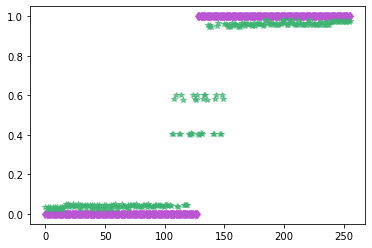

In [8]:
fig, ax = plt.subplots()

ax.plot(y_test, "d", linestyle = "None", color = "mediumorchid", label = "real y")
ax.plot(pred_y, "*", linestyle = "None", color = "mediumseagreen", alpha = 0.7, label = "predicted y")